# Simple CNN Deepfake Classification

Importing packages and setting environment variables

In [17]:
import os
from pathlib import Path

import keras.preprocessing.image_dataset
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as k

from keras.models import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import adam_v2 as Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)
image_path = "../../resources/Processed/cropped150"
df_path = image_path + "/deepfakes/"
or_path = image_path + "/originals/"
image_size = (150, 150)
batch_size = 64
validation_split = 0.2
epochs=100

We need to create training, testing and validation sets. We will start by removing 10% of the data for validation. This data will not be used in model training.
Of the remaining images, 10% will be used as a test images and 90% will be used for training images. There are a number of ways to prepare data; we want to make
use of the ```tf.keras.preprocessing.image_dataset_from_directory``` utility to help streamline preprocessing and allow us to use tensorflow's high-performance
 ```tf.data.Dataset``` object. In order to do so, we need to ensure that the images in the source directory are named appropriately. Confirm that the dataset is
 split into 2 folders named with the image classification of the images they contain, respectively. For example:
 ```shell
 ../cropped150/
    ../deepfakes/
      ..deepfakes_image_1.jpg
      ..deepfakes_image_2.jpg
    ../originals/
      ..originals_image_1.jpg
      ..originals_image_2.jpg
 ```
Our directories are already organized appropriately, but we need to enforce the naming scheme as shown above. We use the following shell script. Note, you will need to change
the path variables to point to the path in your system.

In [17]:
%%sh
DF_PATH="/home/brigugls/repositories/University_Repos/CourseWork/8700Project_DeepFakeDetection/DeepFakeDetected/DeepFakeDetected/DeepFakeDetected/resources/Processed/cropped150/deepfakes/"
OR_PATH="/home/brigugls/repositories/University_Repos/CourseWork/8700Project_DeepFakeDetection/DeepFakeDetected/DeepFakeDetected/DeepFakeDetected/resources/Processed/cropped150/originals/"

echo "Renaming deepfakes. Please wait..."
cd $DF_PATH || return
COUNT=0
for IMAGE in *.jpg; do
  [ -f "$IMAGE" ] || break;
  N=$(printf '%06d' $COUNT);
  mv "$IMAGE" "deepfakes_image_${N}.jpg"
  COUNT=$((COUNT+1))
done
echo $COUNT

echo "Renaming originals. Please wait..."
cd $OR_PATH || return
COUNT=0
for IMAGE in *.jpg; do
  [ -f "$IMAGE" ] || break
  N=$(printf '%06d' $COUNT)
  mv "$IMAGE" "originals_image_${N}.jpg"
  COUNT=$((COUNT+1))
done
echo $COUNT

echo "Complete."

Renaming deepfakes. Please wait...
3466
Renaming originals. Please wait...
3400
Complete.


---
With the files being renamed, we can create the ```tf.data.Dataset``` objects from our data. In the following two lines, we will create two datasets, a training set and a validation set, where the validation set will contain 20% of our data, selected at random.

In [9]:
training_set = keras.preprocessing.image_dataset.image_dataset_from_directory(image_path, batch_size=batch_size, image_size=image_size, validation_split=validation_split, subset="training", seed=seed)

Found 6866 files belonging to 2 classes.
Using 5493 files for training.


In [10]:
validation_set = keras.preprocessing.image_dataset.image_dataset_from_directory(image_path, batch_size=batch_size, image_size=image_size, validation_split=validation_split, subset="validation", seed=seed)

Found 6866 files belonging to 2 classes.
Using 1373 files for validation.


We can confirm the class names to check that the data was loaded correctly.

In [11]:
print(training_set.class_names)
print(validation_set.class_names)

['deepfakes', 'originals']
['deepfakes', 'originals']


With the dataset being created, we should take care of any other preprocessing and preparatory tasks (like data augmentation) now. We start by standardizing data now to between the [0, 1] range as image files store pixel values as [0, 255] integers.

In [15]:
normalization_layer = Rescaling(1./255)
norm_train_set = training_set.map(lambda x, y:(normalization_layer(x), y))
norm_val_set = validation_set.map(lambda x, y:(normalization_layer(x), y))

We can confirm the image values are now standardized within the [0, 1] range in both the training and validation sets.

In [16]:
t_image_batch, t_labels_batch = next(iter(norm_train_set))
v_image_batch, v_labels_batch = next(iter(norm_val_set))
t_first_image = t_image_batch[0]
v_first_image = v_image_batch[0]
print(np.min(t_first_image), np.max(t_first_image))
print(np.min(v_first_image), np.max(v_first_image))

0.0 0.93725497
0.0 1.0


## Defining the Model
We can now define the model to be trained.

An important note: we could also use the normalization layer within the model to simplify deployment. This is the approach we follow.

In [18]:
num_classes = len(training_set.class_names)

model = Sequential([
  Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)), # Here we normalize the data
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

## Model Training
Now we can train the model

In [21]:
# feel free to change epochs here
epochs = 10
history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs,
)

Epoch 1/10


2022-03-30 20:17:28.973360: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.


 1/86 [..............................] - ETA: 1:37 - loss: 0.6929 - accuracy: 0.5156

2022-03-30 20:17:29.262486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.
2022-03-30 20:17:29.378885: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.


 2/86 [..............................] - ETA: 24s - loss: 0.7014 - accuracy: 0.5469 

2022-03-30 20:17:29.562516: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.
2022-03-30 20:17:29.665519: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92160000 exceeds 10% of free system memory.


86/86 [==============================] - 28s 310ms/step - loss: 0.5395 - accuracy: 0.7093 - val_loss: 0.2272 - val_accuracy: 0.9425
Epoch 2/10
86/86 [==============================] - 25s 294ms/step - loss: 0.1125 - accuracy: 0.9678 - val_loss: 0.0445 - val_accuracy: 0.9913
Epoch 3/10
86/86 [==============================] - 25s 291ms/step - loss: 0.0217 - accuracy: 0.9960 - val_loss: 0.0905 - val_accuracy: 0.9680
Epoch 4/10
86/86 [==============================] - 25s 289ms/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 0.0167 - val_accuracy: 0.9971
Epoch 5/10
86/86 [==============================] - 26s 297ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0152 - val_accuracy: 0.9978
Epoch 6/10
86/86 [==============================] - 25s 287ms/step - loss: 0.0155 - accuracy: 0.9965 - val_loss: 0.0146 - val_accuracy: 0.9971
Epoch 7/10
86/86 [==============================] - 25s 289ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.0113 - val_accuracy: 0.9985
Epoch 8/10

## Visualizing Training Results
We can create plots of loss and accuracy on the training and validation sets

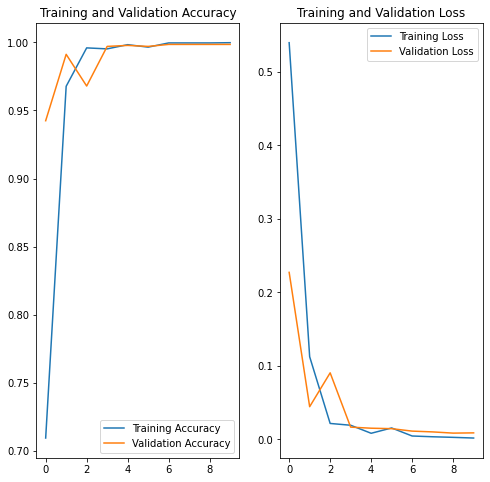

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()